# Assigment 3

This notebook covers the exercises for the next two weeks.

## Exercise 5: Block Matching and Harris Corner Detection

## Ex. 5.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_project = "/content/drive/MyDrive/University/computer vision/"\

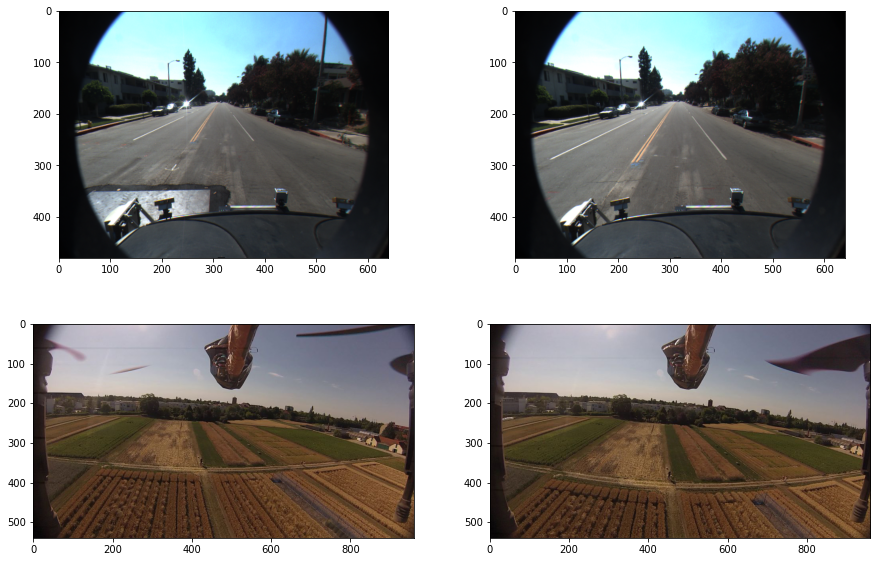

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color, draw
import numpy as np

# Chose other images if you like
lane1 = io.imread(path_to_project + 'images/lane_detection/f00000.png')
lane2 = io.imread(path_to_project + 'images/lane_detection/f00001.png')

# Footage from our Neurocopter project:
# http://berlinbiorobotics.blog/projects/neurocopter/
copter1 = io.imread(path_to_project + 'images/copter_flight/frame050.jpg')
copter2 = io.imread(path_to_project + 'images/copter_flight/frame052.jpg') 

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(copter1)
ax22.imshow(copter2)

In [ ]:
import cv2

def find_vector_flow(image_1, image_2, coords_of_block = (350, 300, 450, 200)):
    """
    image_1: initial image from timestamp 1
    image_2: image from timestamp x

    coords_of_block: tuple with 4 integers indicating bbox (x1, y1, x2, y2)
    """
    x1, y1, x2, y2 = coords_of_block
    width = x2-x1
    height = y1-y2

    image_1 = np.copy(image_1)
    image_2 = np.copy(image_2)

    # extract initial block
    initial_block = image_1[y2 : y1, x1 : x2]
    
    # ranges of x and y-shifts
    delta_x_range = np.arange(-width // 2, width // 2, 1)
    delta_y_range = np.arange(-height // 2, height // 2, 1)

    shifts_arr = np.zeros((len(delta_y_range), len(delta_x_range)))

    # value added to the shift ( to do prober indexing in shifts array )
    x_incrementor = np.abs(delta_x_range[0])
    y_incrementor = np.abs(delta_y_range[0])


    for x_shift in delta_x_range:
        for idx, y_shift in enumerate(delta_y_range):
            
            x1_new, y1_new = x1 + x_shift, y1 + y_shift
            x2_new, y2_new = x2 + x_shift, y2 + y_shift

            new_block = image_2[y2_new : y1_new, x1_new : x2_new]
            
            sim = np.linalg.norm(initial_block * new_block) # np.linalg.norm(initial_block - new_block) 

            shifts_arr[y_shift + y_incrementor, x_shift + x_incrementor] = sim

    min_coords = np.where(shifts_arr == np.min(shifts_arr))

    x1_new, y1_new = x1 + min_coords[1] - x_incrementor, y1 + min_coords[0] - y_incrementor
    x2_new, y2_new = x2 + min_coords[1] - x_incrementor, y2 + min_coords[0] - y_incrementor

    cv2.rectangle(image_1, (x2, y2), (x1, y1) ,(170,110,30),3)

    cv2.rectangle(image_2, (x2, y2), (x1, y1), (170,110,30),3)
    cv2.rectangle(image_2, (x2_new, y2_new), (x1_new, y1_new), (0,255,0),3)
    cv2.putText(image_2, "New block", (x2_new - 50, y2 - 10),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)


    fig, ax = plt.subplots(1,3, figsize = (26,26))
    ax[0].imshow(image_1)
    ax[1].imshow(image_2)





    x,y = np.meshgrid(np.linspace(x1,x2,3),np.linspace(y2,y1,3))

    u = min_coords[1] - x_incrementor
    v = min_coords[0] - y_incrementor

    ax[2].imshow(color.rgb2gray(image_1), cmap = 'gray')
    ax[2].quiver(x,y,u,v, alpha = 0.9)


    plt.show()

    return min_coords

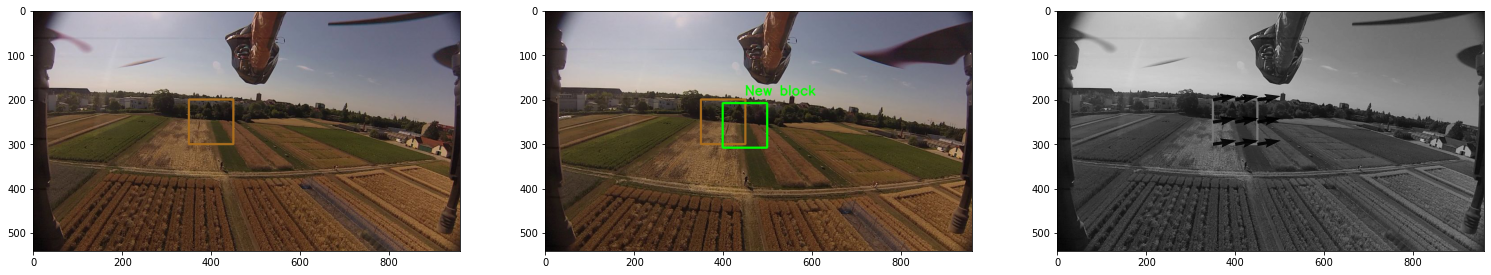

(array([58]), array([99]))

In [ ]:
find_vector_flow(copter1, copter2)

## Ex. 5.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

In [ ]:
# from previous assignment

def conv2d(image, kernel, pad=0.5):
    """
    If kernel has an even number the "hangover pixel"
    will be to the top/left.
    """
    result = np.zeros(image.shape)
    
    # Convert kernel into kernel with even sides
    kernel = np.array(kernel)
    if kernel.shape[0] % 2 == 0:
        new_kernel = np.zeros((kernel.shape[0] + 1, kernel.shape[1]))
        new_kernel[:kernel.shape[0]] = kernel
        kernel = new_kernel
    if kernel.shape[1] % 2 == 0:
        new_kernel = np.zeros((kernel.shape[0], kernel.shape[1] + 1))
        new_kernel[:,:kernel.shape[1]] = kernel
        kernel = new_kernel
    
    # pad the image
    pad_y, pad_x = kernel.shape[0] // 2, kernel.shape[1] // 2
        
    padded = np.empty((image.shape[0] + pad_y * 2, image.shape[1] + pad_x * 2))
    if not pad_y and not pad_x:
        raise Exception("Bad Kernel")
    elif not pad_y:
        padded[:, pad_x:-pad_x] = image
        padded[:,:pad_x], padded[:,-pad_x:] = pad, pad
    elif not pad_x:
        padded[pad_y:-pad_y,:] = image
        padded[:pad_y], padded[-pad_y:] = pad, pad
    else:
        padded[pad_y:-pad_y, pad_x:-pad_x] = image
        padded[:pad_y], padded[-pad_y:] = pad, pad
        padded[:,:pad_x], padded[:,-pad_x:] = pad, pad

    # Shift image for every kernel value
    for kernel_y in range(kernel.shape[0]):
        for kernel_x in range(kernel.shape[1]):
            displacement_y = kernel_y + image.shape[0]
            displacement_x = kernel_x + image.shape[1]

            shifted_image = np.empty_like(image)
            shifted_image = padded[kernel_y:displacement_y, kernel_x:displacement_x]
            
            result += shifted_image * kernel[kernel_y, kernel_x]

    kernel_sum = np.sum(kernel)
    return result / kernel_sum if kernel_sum else result

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)


def gaussian_kernel(size, sigma=1, verbose=False):
 
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Image")
        plt.show()
 
    return kernel_2D


In [ ]:
def get_harris_responce(img, k = 0.05):
    
    if len(img.shape) > 2:
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img

    # apply sobel kernel to find gradients
    sobel_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

    # compute x and y derivatives of image
    gradient_along_x = conv2d(img_gray, sobel_kernel)
    gradient_along_y = conv2d(img_gray,sobel_kernel.T)
    gradient_magnitude = np.sqrt(np.square(gradient_along_x) + np.square(gradient_along_y))
    # compute products of derivatives at every pixel
    gradient_along_x2 = gradient_along_x * gradient_along_x
    gradient_along_y2 = gradient_along_y * gradient_along_y
    gradient_along_xy = gradient_along_x * gradient_along_y

    # compute the sums of the products of derivatives at each pixel (apply gaussian filter)
    kernel_gaus = gaussian_kernel(3,1)

    gradient_along_x2 = conv2d(gradient_along_x2, kernel_gaus)
    gradient_along_y2 = conv2d(gradient_along_y2, kernel_gaus)
    gradient_along_xy = conv2d(gradient_along_xy, kernel_gaus)

    # compute the response of the detector at each pixel
    det = gradient_along_x2 * gradient_along_y2 - gradient_along_xy * gradient_along_xy
    trace = gradient_along_x2 + gradient_along_y2

    r = det - k * (trace ** 2)

    return r


In [ ]:
def get_corners_coords(img, threshold_percentile = 95):
    
    harris_response = get_harris_responce(img)
    image_with_corners = np.copy(img)
    corners_coords = np.zeros_like(harris_response)

    threshold = np.percentile(harris_response, threshold_percentile)

    # iterate through values of harris response at each pixel
    for y in range(harris_response.shape[0]):
        for x in range(harris_response.shape[1]):
            if harris_response[y, x] > threshold:
                corners_coords[y, x] += 1
                image_with_corners[y, x] = [255,0,0]

    plt.imshow(image_with_corners)
    return corners_coords

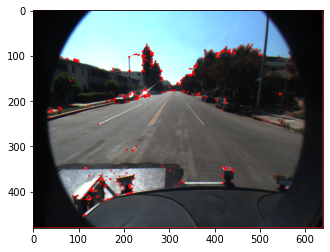

In [ ]:
corners_coords_lane1 = get_corners_coords(img = lane1, threshold_percentile = 98)

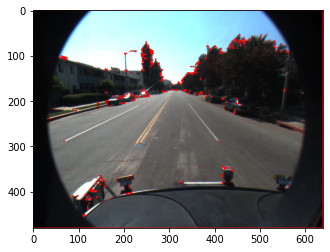

In [ ]:
corners_coords_lane2 = get_corners_coords(img = lane2, threshold_percentile = 98)

### Lukas-Kanade corner tracking 

In [ ]:
?cv2.calcOpticalFlowPyrLK  # np.where(corners_coords_lane2 !=0 ) 

In [ ]:
# nextPts, status, err = cv2.calcOpticalFlowPyrLK(prevImg = lane1, nextImg = lane2, prevPts = corners_coords_lane1, nextPts = None )
prevImg = np.copy(cv2.cvtColor(lane1, cv2.COLOR_BGR2GRAY))
corners_coords_lane1_reshaped = np.copy(np.stack(np.where(corners_coords_lane1 != 0)).reshape(-1,2)).astype('float32')
corners_coords_lane2_reshaped = np.copy(np.stack(np.where(corners_coords_lane2 != 0)).reshape(-1,2)).astype('float32')



nextPts, status, err = cv2.calcOpticalFlowPyrLK(prevImg = prevImg, nextImg = cv2.cvtColor(lane2, cv2.COLOR_BGR2GRAY), prevPts = corners_coords_lane1_reshaped, nextPts = None )

In [ ]:
# Select good points
good_new = nextPts[(status == 1).flatten()]
good_old = corners_coords_lane1_reshaped[(status == 1).flatten()]

In [ ]:
# Create some random colors
color = np.random.randint(0,255,(100,3))

prevImg = np.copy(cv2.cvtColor(lane1, cv2.COLOR_BGR2GRAY))

# draw the tracks
for idx, (new, old) in enumerate(zip(good_new, 
                                    good_old)):
    a, b = new.ravel()
    c, d = old.ravel()

    prevImg = cv2.line(prevImg, (a, b), (c, d), 255, 2)
        
    prevImg = cv2.circle(prevImg, (a, b), 5, [255], -1)

    if (idx+1) % 2000 == 0:
        break

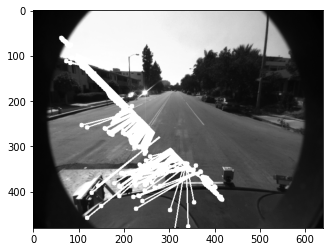

In [ ]:
plt.imshow(prevImg, cmap = 'gray')

## Exercise 6: Viola & Jones
Read the paper by Viola and Jones. You can find it in "mycampus/resources/papers".

## Ex. 6.1 Rectangular Features
Implement the construction of all 2-rect features (horizontal and vertical) within a given window (like the 24x24 px window from the paper). How many exist? **(RESULT)** Display three of these overlaid onto an image of a face. **(RESULT)**

In [ ]:
!mkdir data
!wget http://www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz
!tar -xzvf "/content/faces.tar.gz" -C "/content/data/"
!tar -xzvf "/content/data/face.train.tar.gz" -C "/content/data/"

Streaming output truncated to the last 5000 lines.
train/face/face01979.pgm
train/face/face01980.pgm
train/face/face01981.pgm
train/face/face01982.pgm
train/face/face01983.pgm
train/face/face01984.pgm
train/face/face01985.pgm
train/face/face01986.pgm
train/face/face01987.pgm
train/face/face01988.pgm
train/face/face01989.pgm
train/face/face01990.pgm
train/face/face01991.pgm
train/face/face01992.pgm
train/face/face01993.pgm
train/face/face01994.pgm
train/face/face01995.pgm
train/face/face01996.pgm
train/face/face01997.pgm
train/face/face01998.pgm
train/face/face01999.pgm
train/face/face02000.pgm
train/face/face02001.pgm
train/face/face02002.pgm
train/face/face02003.pgm
train/face/face02004.pgm
train/face/face02005.pgm
train/face/face02006.pgm
train/face/face02007.pgm
train/face/face02008.pgm
train/face/face02009.pgm
train/face/face02010.pgm
train/face/face02011.pgm
train/face/face02012.pgm
train/face/face02013.pgm
train/face/face02014.pgm
train/face/face02015.pgm
train/face/face02016.pgm

In [ ]:
import os
from skimage import io
positive_data = '/content/data/train/face'
negative_data = '/content/data/train/non-face'

data = []
labels = []

for file_name in os.listdir(positive_data):
  x = io.imread(os.path.join(positive_data,file_name),as_gray = True)
  y = 1
  data.append(x)
  labels.append(y)

for file_name in os.listdir(negative_data):
  x = io.imread(os.path.join(negative_data,file_name),as_gray = True)
  y = -1
  data.append(x)
  labels.append(y)



face1 = data[0]

In [ ]:
np.unique(labels, return_counts = True)

(array([-1,  1]), array([4548, 2429]))

In [ ]:
import numpy as np

class RectangleRegion:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    
    def compute_feature(self, ii):
        """
        Computes the value of the Rectangle Region given the integral image
        Args:
            integral image : numpy array, shape (m, n)
            x: x coordinate of the upper left corner of the rectangle
            y: y coordinate of the upper left corner of the rectangle
            width: width of the rectangle
            height: height of the rectangle
        """
        return ii[self.y+self.height][self.x+self.width] + ii[self.y][self.x] - (ii[self.y+self.height][self.x]+ii[self.y][self.x+self.width])

def build_features(image_shape):
        """
        Builds the possible features given an image shape
          Args:
            image_shape: a tuple of form (height, width)
          Returns:
            an array of tuples. Each tuple's first element is an array of the rectangle regions which positively contribute to the feature. The second element is an array of rectangle regions negatively contributing to the feature
        """
        height, width = image_shape
        features = []
        for w in range(1, width+1):
            for h in range(1, height+1):
                i = 0
                while i + w < width:
                    j = 0
                    while j + h < height:
                        #2 rectangle features
                        immediate = RectangleRegion(i, j, w, h)
                        right = RectangleRegion(i+w, j, w, h)
                        if i + 2 * w < width: #Horizontally Adjacent
                            features.append(([right], [immediate]))

                        bottom = RectangleRegion(i, j+h, w, h)
                        if j + 2 * h < height: #Vertically Adjacent
                            features.append(([immediate], [bottom]))                    

                        j += 1
                    i += 1
        return np.array(features)

features_face = build_features(data[0].shape)


Text(0.5, 1.0, 'Positive horizontal')

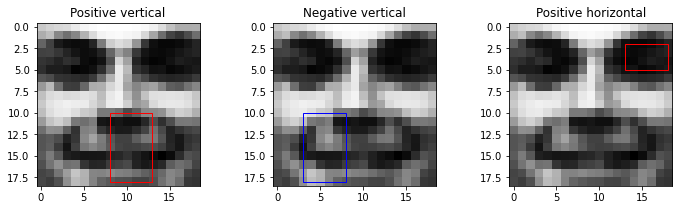

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
def drawROI(image, rec, out = plt, color='red'):
    out.add_patch(
        patches.Rectangle(
            (rec.x, rec.y),
            rec.width,
            rec.height,
            fill=False,
            edgecolor=color
        )
    )
    
    out.imshow(image, cmap='gray')

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 3))

drawROI(face1, features_face[17000][0][0], ax0)
ax0.set_title("Positive vertical")
drawROI(face1, features_face[17000][1][0], ax1, 'blue')
ax1.set_title("Negative vertical")
drawROI(face1, features_face[16000][0][0], ax2)
ax2.set_title("Positive horizontal")

## Ex. 6.2 Integral Image
Implement a function that computes the integral image of a given input image. Display the integral image for an input of you choice **(RESULT)**. Compare it to the output of skimage's integral_image() function. **(RESULT)**

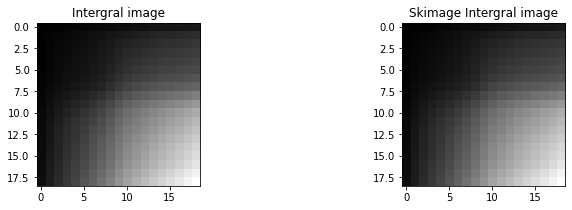

In [ ]:
import skimage.transform
def integral_image(image):
    """
    Computes the integral image representation of a picture. The integral image is defined as following:
    1. s(x, y) = s(x, y-1) + i(x, y), s(x, -1) = 0
    2. ii(x, y) = ii(x-1, y) + s(x, y), ii(-1, y) = 0
    Where s(x, y) is a cumulative row-sum, ii(x, y) is the integral image, and i(x, y) is the original image.
    The integral image is the sum of all pixels above and left of the current pixel
      Args:
        image : an numpy array with shape (m, n)
    """
    ii = np.zeros(image.shape)
    s = np.zeros(image.shape)
    for y in range(len(image)):
        for x in range(len(image[y])):
            s[y][x] = s[y-1][x] + image[y][x] if y-1 >= 0 else image[y][x]
            ii[y][x] = ii[y][x-1]+s[y][x] if x-1 >= 0 else s[y][x]
    return ii

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 3))
ax0.set_title("Intergral image")
ax0.imshow(integral_image(face1) , cmap='gray')
ax1.set_title("Skimage Intergral image")
ax1.imshow(skimage.transform.integral.integral_image(face1) , cmap='gray')

## Ex. 6.3 AdaBoosting
Implement the AdaBoost algorithm as outlined in the paper. Train a 20-feature classifier using these datasets:

faces and non-faces:    www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz

Test your classifier with different thesholds and visualize the ROC curve **(RESULTS)**

In [165]:
#test = load_test()

!tar -xzvf "/content/data/face.test.tar.gz" -C "/content/data/"

positive_data = '/content/data/test/face'
negative_data = '/content/data/test/non-face'

data_test = []
labels_test = []

for file in os.listdir(positive_data):
  x = io.imread(os.path.join(positive_data,file),as_gray = True)
  y = 1
  data_test.append(x)
  labels_test.append(y)

for file in os.listdir(negative_data):
  x = io.imread(os.path.join(negative_data,file),as_gray = True)
  y = -1
  data_test.append(x)
  labels_test.append(y)
print(np.unique(labels_test, return_counts = True))

Streaming output truncated to the last 5000 lines.
test/non-face/cmu_5001.pgm
test/non-face/cmu_5002.pgm
test/non-face/cmu_5003.pgm
test/non-face/cmu_5004.pgm
test/non-face/cmu_5005.pgm
test/non-face/cmu_5006.pgm
test/non-face/cmu_5007.pgm
test/non-face/cmu_5008.pgm
test/non-face/cmu_5009.pgm
test/non-face/cmu_5010.pgm
test/non-face/cmu_5011.pgm
test/non-face/cmu_5012.pgm
test/non-face/cmu_5013.pgm
test/non-face/cmu_5014.pgm
test/non-face/cmu_5015.pgm
test/non-face/cmu_5016.pgm
test/non-face/cmu_5017.pgm
test/non-face/cmu_5018.pgm
test/non-face/cmu_5019.pgm
test/non-face/cmu_5020.pgm
test/non-face/cmu_5021.pgm
test/non-face/cmu_5022.pgm
test/non-face/cmu_5023.pgm
test/non-face/cmu_5024.pgm
test/non-face/cmu_5025.pgm
test/non-face/cmu_5026.pgm
test/non-face/cmu_5027.pgm
test/non-face/cmu_5028.pgm
test/non-face/cmu_5029.pgm
test/non-face/cmu_5030.pgm
test/non-face/cmu_5031.pgm
test/non-face/cmu_5032.pgm
test/non-face/cmu_5033.pgm
test/non-face/cmu_5034.pgm
test/non-face/cmu_5035.pgm
test

In [ ]:
# extract 2-rect features

# integral_image(face1)

def extract_n_features(img, n_features = 20, rect=np.ones((4,2))):
    
    img = integral_image(img)

    y = 2
    x = 2

    features = []

    for i in range(int(n_features//2)):
        region_pos = img[y: y + rect.shape[0], x: x + rect.shape[1]]
        pos = region_pos[-1][1] - region_pos[-1][0] - region_pos[0][1] + region_pos[0][0]

        region_neg = img[y: y + rect.shape[0], x + rect.shape[1]: x + rect.shape[1] * 2]
        neg = region_neg[-1][1] - region_neg[-1][0] - region_neg[0][1] + region_neg[0][0]
        y += 1
        x += 1
        features.append(pos - neg)
    y = 2
    x = 2
    rect = rect.T
    for i in range(int(n_features // 2)):
        region_pos = img[y: y + rect.shape[0], x: x + rect.shape[1]]
        pos = region_pos[-1][1] - region_pos[-1][0] - region_pos[0][1] + region_pos[0][0]

        region_neg = img[y: y + rect.shape[0], x + rect.shape[1]: x + rect.shape[1] * 2]
        neg = region_neg[-1][1] - region_neg[-1][0] - region_neg[0][1] + region_neg[0][0]
        y += 1
        x += 1
        features.append(pos - neg)

    return features

In [ ]:
from tqdm import tqdm

n_features = 20
train_features_array = np.empty((len(data), n_features))

for idx, img in tqdm(enumerate(data)):
    features = extract_n_features(img)
    train_features_array[idx,:] = features

In [ ]:
test_features_array = np.empty((len(data_test), n_features))

for idx, img in tqdm(enumerate(data_test)):
    features = extract_n_features(img)
    test_features_array[idx, :] = features

In [ ]:
# helping functions
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report

In [172]:
class Classifier:
  
    def accuracy(self, labels, predictions):
        return np.mean(labels == predictions)
    
    def confusion_matrix(self, labels, predictions):
        size = len(set(labels))
        matrix = np.zeros((size, size))
        for correct, predicted in zip(labels.astype(int), predictions.astype(int)):
            matrix[correct][predicted] += 1
        return matrix

        
class DecisionStump(Classifier):
    def __init__(self, feature, label, alternative_label, threshold=0):
        self.feature = feature
        self.label = label
        self.alternative_label = alternative_label
        self.threshold = threshold
        
    def predict(self, X):
        return np.where(X[:, self.feature] >= self.threshold, self.label, self.alternative_label)


def create_classifier_pool(X):
    classifier_pool = []

    for feature in range(X.shape[1]):
        for threshold in sorted(set(X[:, feature])):
            classifier_pool += [
                DecisionStump(feature, 1, -1, threshold),
                DecisionStump(feature, -1, 1, threshold)
            ]
            
    return classifier_pool


class AdaBoost(Classifier):
    def __init__(self, classifier_pool, num_classifiers):
        self.classifier_pool = list(classifier_pool)
        self.num_classifiers = num_classifiers
        
        self.classifiers = []
        self.weights = []
        
    def fit(self, X, y):
        scouting_matrix = np.array([clf.predict(X) != y for clf in self.classifier_pool])
        w = np.ones(len(y)) # Initially, all weights are the same
        
        for _ in range(self.num_classifiers):
            # Step 1
            errors = scouting_matrix@w
            best_remaining = errors.argmin()
            
            # Step 2
            We = errors[best_remaining]
            W = w.sum()
            em = (W - We) / W
                        
            self.classifiers += [self.classifier_pool[best_remaining]]
            self.weights += [0.5 * -np.log((1 - em) / em)] # alphas
            
            # Step 3
            w = w * np.exp(np.where(scouting_matrix[best_remaining], 1, -1) * self.weights[-1])
            scouting_matrix = np.delete(scouting_matrix, best_remaining, axis=0)
            del self.classifier_pool[best_remaining]
        
    def predict(self, X, return_weighted_preds = False):
        preds = np.array([cl.predict(X) for cl in self.classifiers])
        weighted_preds = np.dot(self.weights, preds)
        if return_weighted_preds:
            return weighted_preds
        
        return np.where(weighted_preds >= 0, 1, -1)

In [173]:
classifier_pool = create_classifier_pool(train_features_array)
print ("Created %d weak learners" % len(classifier_pool))

Created 19266 weak learners


In [174]:
model = AdaBoost(classifier_pool, num_classifiers=200)
model.fit(train_features_array, labels)


In [175]:

predictions = model.predict(train_features_array)
print("\nTrain: ", classification_report(labels, predictions))

predictions = model.predict(test_features_array)
print("\nTest: ", classification_report(labels_test, predictions))


Train:                precision    recall  f1-score   support

          -1       0.95      0.95      0.95      4548
           1       0.91      0.91      0.91      2429

    accuracy                           0.94      6977
   macro avg       0.93      0.93      0.93      6977
weighted avg       0.94      0.94      0.94      6977


Test:                precision    recall  f1-score   support

          -1       0.98      0.97      0.98     23573
           1       0.12      0.22      0.15       472

    accuracy                           0.95     24045
   macro avg       0.55      0.59      0.56     24045
weighted avg       0.97      0.95      0.96     24045



### Plot ROC

In [185]:
def sigmoid(x):

    return 1 / ( 1 + np.exp(-x))

sigmoid_vec = np.vectorize(sigmoid)

weighted_preds = model.predict(test_features_array, return_weighted_preds = True)
preds_probabilities = sigmoid_vec(weighted_preds)

No handles with labels found to put in legend.


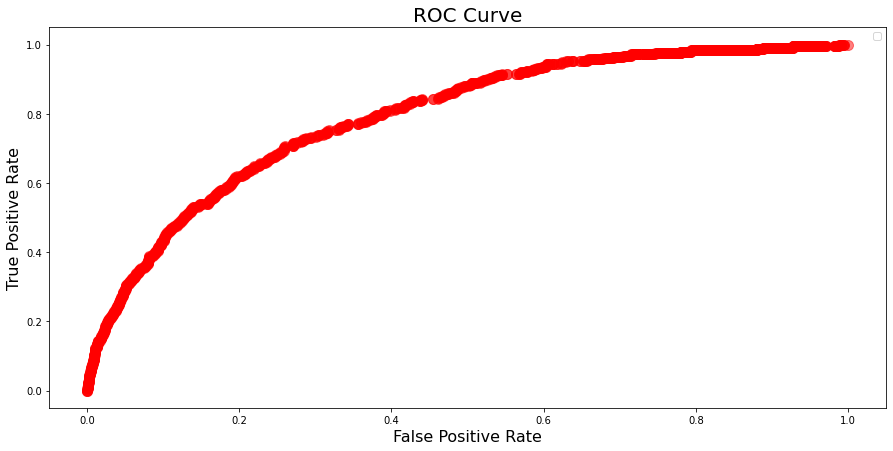

In [186]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels_test, preds_probabilities)


plt.figure(figsize=(15, 7))
plt.scatter(fpr, tpr, s=100, alpha=0.5, color="red")

plt.title("ROC Curve", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.legend()

### Congratz, you made it through Assignment 3! You can now try to solve this optional exercise.

This exercise is not graded, but might be a good preparation for the exam.

Please go to the following link: https://forms.gle/f7mx9SM2J2vUHwMo9.

In the form, you will find the optional task (and the corresponding consent form in case you agree with us processing your data). The task is formulated in German, and we would prefer German as the language for your answer. However, if you don’t feel comfortable with that, please feel free to solve it in English.


